# Bi-LSTM solution to NLI problem - Category B

1. Data Loading and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Bidirectional

# Load the datasets
train_data = pd.read_csv('train.csv')
dev_data = pd.read_csv('dev.csv')

# Fill NaN values to ensure text processing does not error out
train_data.fillna('', inplace=True)
dev_data.fillna('', inplace=True)

# Combine 'premise' and 'hypothesis' into a single text column and clean the text
train_data['text'] = train_data['premise'].str.cat(train_data['hypothesis'], sep=' ').str.replace('[^\w\s]', '').str.lower()
dev_data['text'] = dev_data['premise'].str.cat(dev_data['hypothesis'], sep=' ').str.replace('[^\w\s]', '').str.lower()

# Tokenize text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])  # Only fit on train data to avoid data leakage
X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_dev_seq = tokenizer.texts_to_sequences(dev_data['text'])

# Pad sequences
max_len = 100  # Maximum length of the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_len)

y_train = train_data['label'].values
y_dev = dev_data['label'].values

2. Define and Compile the LSTM Model


In [ ]:
# Define the model architecture with Bidirectional LSTM
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=10000, output_dim=100, input_length=max_len)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(64))(embedding_layer)  # Adding Bidirectional here
dropout_layer = Dropout(0.5)(bi_lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

3. Train the Model

In [ ]:
# Train the model
model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_dev_pad, y_dev))

Epoch 1/10
842/842 [==============================] - 128s 147ms/step - loss: 0.6398 - accuracy: 0.6298 - val_loss: 0.6142 - val_accuracy: 0.6561
Epoch 2/10
842/842 [==============================] - 121s 144ms/step - loss: 0.5515 - accuracy: 0.7202 - val_loss: 0.6256 - val_accuracy: 0.6481
Epoch 3/10
842/842 [==============================] - 120s 142ms/step - loss: 0.4504 - accuracy: 0.7852 - val_loss: 0.7039 - val_accuracy: 0.6387
Epoch 4/10
842/842 [==============================] - 115s 137ms/step - loss: 0.3411 - accuracy: 0.8450 - val_loss: 0.8873 - val_accuracy: 0.6305
Epoch 5/10
842/842 [==============================] - 116s 138ms/step - loss: 0.2505 - accuracy: 0.8889 - val_loss: 1.0549 - val_accuracy: 0.6159
Epoch 6/10
842/842 [==============================] - 115s 136ms/step - loss: 0.1816 - accuracy: 0.9239 - val_loss: 1.2464 - val_accuracy: 0.6175
Epoch 7/10
842/842 [==============================] - 115s 137ms/step - loss: 0.1301 - accuracy: 0.9479 - val_loss: 1.6143 -

4. Evaluate on Development Data

In [ ]:
y_dev_pred = model.predict(X_dev_pad)
y_dev_pred = (y_dev_pred > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_dev, y_dev_pred))

# Calculate accuracy
accuracy = (y_dev_pred.flatten() == y_dev).mean()
print(f"Accuracy: {accuracy}")

211/211 [==============================] - 9s 38ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59      3259
           1       0.61      0.62      0.62      3478

    accuracy                           0.60      6737
   macro avg       0.60      0.60      0.60      6737
weighted avg       0.60      0.60      0.60      6737

Accuracy: 0.6026421255751818


5. Plot Confusion Matrix

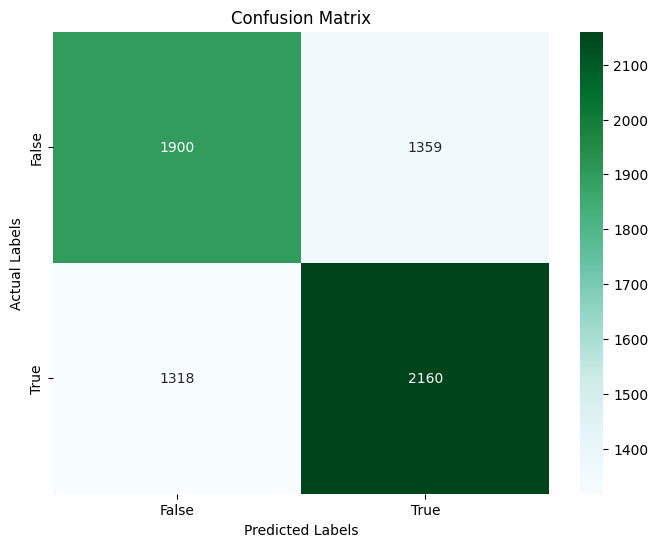

In [ ]:
cm = confusion_matrix(y_dev, y_dev_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='BuGn', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

6. Save Predictions to CSV

In [ ]:
predictions_df = pd.DataFrame(y_dev_pred, columns=['prediction'])
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'


7. Save Bi-LSTM model and the tekonizer in order to be used in the Demo-code Notebook

In [ ]:
from keras.models import load_model

# Save the LSTM model using Keras' own save function to an HDF5 file
model.save('Bi-lstm_model.h5')

# Save the tokenizer using joblib
import joblib
joblib.dump(tokenizer, 'tokenizer.joblib')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['tokenizer.joblib']